In [3]:

# AKAZE (Accelerated KAZE) + Brute-Force Matcher with Hamming Distance。AKAZE 是一种高效的特征提取算法，它生成的描述符是二进制的，适合使用 Hamming 距离进行匹配

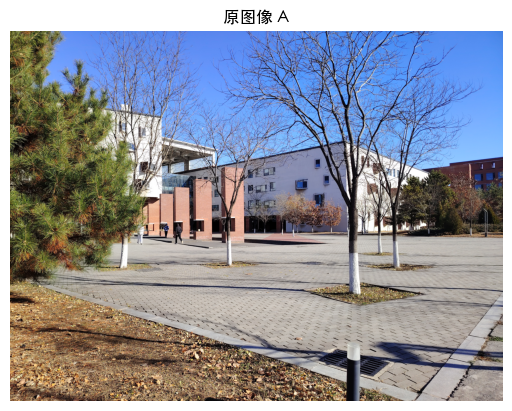

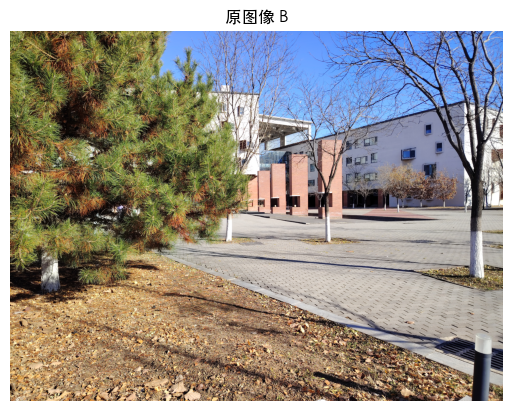

图像 A 特征点数量: 108037
图像 B 特征点数量: 136374


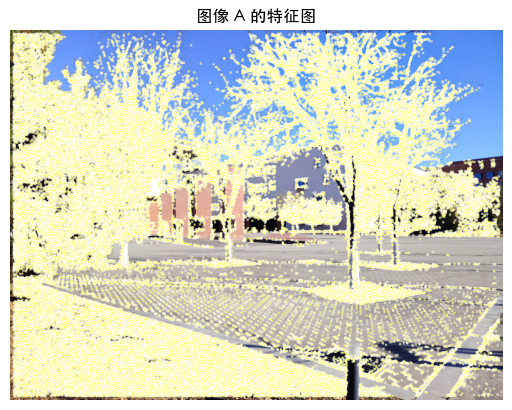

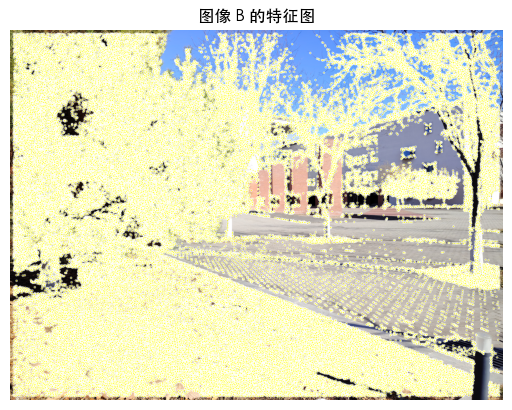

使用 BFMatcher_AKAZE 匹配的总匹配点数量：3541
平均匹配距离（通过比率测试的匹配）：37.40


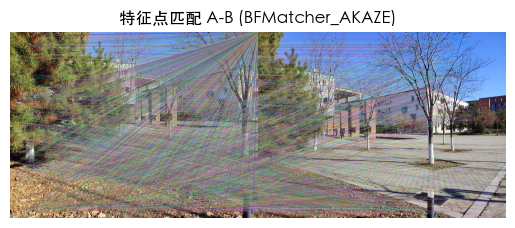

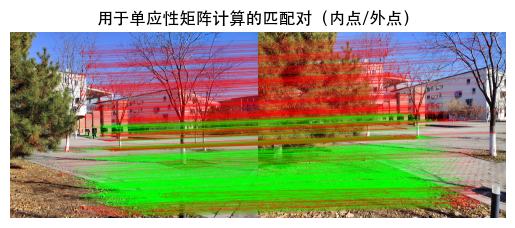

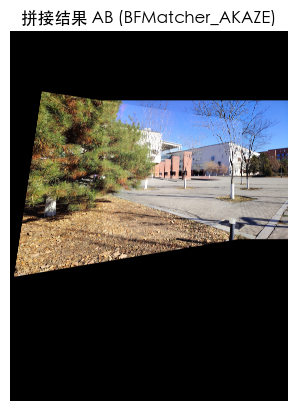

内点数量：2077 / 3541
内点比例：0.59
拼接结果已保存至: ./output_BFMatcher_AKAZE/stitched_3_4.jpg
===== 耗时统计 =====
特征点检测与描述符提取耗时: 1.3226 秒
特征点匹配耗时: 19.8898 秒
图像拼接耗时: 0.6857 秒


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time  # 如果需要评估耗时，可以导入 time

# 设置全局字体
plt.rcParams['font.sans-serif'] = ['STHeiti']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# ============================
# 配置参数
# ============================

imageA_path = "../datasets/new_data/3.jpg"  # 图像 A 的路径
imageB_path = "../datasets/new_data/4.jpg"  # 图像 B 的路径

# 匹配参数
distance_ratio = 0.5       # Lowe 的比率测试中的距离比
ransac_threshold = 5       # RANSAC 阈值
min_matches_required = 4   # 计算单应性矩阵所需的最小匹配点数量

# ============================
# 函数定义
# ============================

def show_image(image, title="Image"):
    """
    显示图像的辅助函数，支持彩色和灰度图显示
    """
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def detectAndDescribe(image):
    """
    使用 AKAZE 进行特征点检测和描述
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 使用 AKAZE 提取特征
    descriptor = cv2.AKAZE_create()
    kps, des = descriptor.detectAndCompute(gray, None)
    kps_float = np.float32([kp.pt for kp in kps])
    return kps, kps_float, des

def match_keypoints_with_akaze(desA, desB):
    """
    使用 BFMatcher + Hamming 距离匹配 AKAZE 特征，并使用 Lowe 比率测试
    """
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    raw_matches = matcher.knnMatch(desA, desB, 2)

    good_matches = []
    matches = []
    # 用于计算平均距离的暂存列表
    distances = []

    for m, n in raw_matches:
        if m.distance < distance_ratio * n.distance:
            good_matches.append([m])
            matches.append((m.queryIdx, m.trainIdx))
            distances.append(m.distance)

    # 计算平均匹配距离（仅限通过比率测试的匹配）
    if len(distances) > 0:
        avg_distance = np.mean(distances)
    else:
        avg_distance = -1  # 表示无有效匹配

    return good_matches, matches, avg_distance

def draw_matches(imageA, kpsA, imageB, kpsB, good_matches):
    """
    绘制两个图像之间的匹配结果
    """
    vis = cv2.drawMatchesKnn(imageB, kpsB, imageA, kpsA,
                             good_matches, None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return vis

def stitch_images(center_image, align_image, center_kps_float, align_kps_float, matches):
    """
    利用匹配点计算单应性矩阵并进行图像拼接，同时返回内点数等信息
    """
    if len(matches) > min_matches_required:
        pts_center = np.float32([center_kps_float[i] for (i, _) in matches])
        pts_align = np.float32([align_kps_float[j] for (_, j) in matches])

        # 使用 RANSAC 计算单应性矩阵
        H, status = cv2.findHomography(pts_align, pts_center, cv2.RANSAC, ransac_threshold)

        inlier_count = 0
        if status is not None:
            inlier_count = np.sum(status)  # 内点数量
        total_count = len(matches)
        inlier_ratio = inlier_count / total_count if total_count > 0 else 0

        # 创建合并的图像用于显示匹配对
        combined_image = np.hstack((center_image, align_image))
        offset = center_image.shape[1]

        # 绘制匹配对（内点用绿色，外点用红色）
        if status is not None:
            for (pt_center, pt_align, st) in zip(pts_center, pts_align, status):
                pt_center = (int(pt_center[0]), int(pt_center[1]))
                pt_align = (int(pt_align[0] + offset), int(pt_align[1]))
                if st == 1:
                    cv2.circle(combined_image, pt_center, 5, (0, 255, 0), -1)   # 内点（绿色）
                    cv2.circle(combined_image, pt_align, 5, (0, 255, 0), -1)
                    cv2.line(combined_image, pt_center, pt_align, (0, 255, 0), 1)
                else:
                    cv2.circle(combined_image, pt_center, 5, (0, 0, 255), -1)   # 外点（红色）
                    cv2.circle(combined_image, pt_align, 5, (0, 0, 255), -1)
                    cv2.line(combined_image, pt_center, pt_align, (0, 0, 255), 1)

        show_image(combined_image, "用于单应性矩阵计算的匹配对（内点/外点）")

        if H is not None:
            # 拼接图像
            height_center, width_center = center_image.shape[:2]
            canvas_size = (height_center * 2, width_center * 2)
            translation_dist = (canvas_size[1] // 4, canvas_size[0] // 4)
            H_translation = np.array([[1, 0, translation_dist[0]],
                                      [0, 1, translation_dist[1]],
                                      [0, 0, 1]], dtype=np.float32)

            result = cv2.warpPerspective(center_image, H_translation, canvas_size)
            H_combined = H_translation @ H
            warped_align = cv2.warpPerspective(align_image, H_combined, canvas_size)
            result = np.maximum(result, warped_align)

            return result, inlier_count, total_count, inlier_ratio
        else:
            return None, inlier_count, total_count, 0
    else:
        print(f"未找到足够的匹配点（需要至少 {min_matches_required} 个）")
        return None, 0, 0, 0

def show_keypoints(image, keypoints, title="Keypoints"):
    """
    显示特征点，并使用亮色和较大尺寸的圆圈标注特征点位置
    """
    image_with_keypoints = image.copy()
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        cv2.circle(image_with_keypoints, (x, y), 8, (255, 255, 255), 2)  # 外圈白色
        cv2.circle(image_with_keypoints, (x, y), 4, (0, 255, 255), -1)   # 内圈亮黄色
    show_image(image_with_keypoints, title)


# ============================
# 主流程
# ============================

if __name__ == "__main__":
    # 1. 加载图像
    imageA = cv2.imread(imageA_path)
    imageB = cv2.imread(imageB_path)

    if imageA is None or imageB is None:
        print("Error: Could not load one or both images.")
        exit(1)

    show_image(imageA, '原图像 A')
    show_image(imageB, '原图像 B')

    # 2. 特征点检测与描述符提取
    start_time = time.time()  # 记录开始时间
    kpsA, kps_floatA, desA = detectAndDescribe(imageA)
    kpsB, kps_floatB, desB = detectAndDescribe(imageB)
    detect_time = time.time() - start_time  # 检测与描述符提取阶段耗时

    # 输出特征点数量
    print(f"图像 A 特征点数量: {len(kpsA)}")
    print(f"图像 B 特征点数量: {len(kpsB)}")

    # 显示特征点（可注释掉以节省运行时间）
    show_keypoints(imageA, kpsA, '图像 A 的特征图')
    show_keypoints(imageB, kpsB, '图像 B 的特征图')

    # 3. 特征匹配
    start_time = time.time()
    good_matches_AB, matches_AB, avg_distance_AB = match_keypoints_with_akaze(desA, desB)
    match_time = time.time() - start_time  # 匹配阶段耗时

    print(f"使用 BFMatcher_AKAZE 匹配的总匹配点数量：{len(good_matches_AB)}")
    print(f"平均匹配距离（通过比率测试的匹配）：{avg_distance_AB:.2f}" if avg_distance_AB != -1 else "暂无有效匹配，无法计算平均距离")

    # 显示匹配结果
    vis_AB = draw_matches(imageA, kpsA, imageB, kpsB, good_matches_AB)
    if vis_AB is not None:
        show_image(vis_AB, '特征点匹配 A-B (BFMatcher_AKAZE)')

    # 4. 图像拼接
    start_time = time.time()
    stitchedAB, inlier_count, total_count, inlier_ratio = stitch_images(
        imageA, imageB, kps_floatA, kps_floatB, matches_AB
    )
    stitch_time = time.time() - start_time

    if stitchedAB is not None:
        show_image(stitchedAB, '拼接结果 AB (BFMatcher_AKAZE)')

        # 输出内点数量、内点比例
        print(f"内点数量：{inlier_count} / {total_count}")
        print(f"内点比例：{inlier_ratio:.2f}")

        # 保存拼接结果
        baseA = os.path.basename(imageA_path)[-7:-4]
        baseB = os.path.basename(imageB_path)[-7:-4]
        output_filename = f"./output_BFMatcher_AKAZE/stitched_{baseA}_{baseB}.jpg"
        os.makedirs('./output_BFMatcher_AKAZE', exist_ok=True)
        cv2.imwrite(output_filename, stitchedAB)
        print(f"拼接结果已保存至: {output_filename}")
    else:
        print("由于匹配点不足，拼接失败。")

    # 5. 耗时统计
    print("===== 耗时统计 =====")
    print(f"特征点检测与描述符提取耗时: {detect_time:.4f} 秒")
    print(f"特征点匹配耗时: {match_time:.4f} 秒")
    print(f"图像拼接耗时: {stitch_time:.4f} 秒")